In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
from functools import reduce

In [3]:
import pandas as pd
import glob


In [4]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CSV Merger").enableHiveSupport().getOrCreate()



# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [5]:
def create_dict_from_csv(file_path):
    df = pd.read_csv(file_path)
    df['file_name'] = df['file_name'].str[:2]
    result_dict = pd.Series(df['file_name'].values, index=df['state']).to_dict()
    return result_dict

# Example usage
file_path = r'/home/talentum/myproject/dataSource/stations_info.csv'
state_dict = create_dict_from_csv(file_path)
print(state_dict)


{'Andhra Pradesh': 'AP', 'Arunachal Pradesh': 'AR', 'Assam': 'AS', 'Bihar': 'BR', 'Chhattisgarh': 'CG', 'Chandigarh': 'CH', 'Delhi': 'DL', 'Gujarat': 'GJ', 'Himachal Pradesh': 'HP', 'Haryana': 'HR', 'Jharkhand': 'JH', 'Jammu and Kashmir': 'JK', 'Karnataka': 'KA', 'Kerala': 'KL', 'Maharashtra': 'MH', 'Meghalaya': 'ML', 'Manipur': 'MN', 'Madhya Pradesh': 'MP', 'Mizoram': 'MZ', 'Nagaland': 'NL', 'Odisha': 'OR', 'Punjab': 'PB', 'Puducherry': 'PY', 'Rajasthan': 'RJ', 'Sikkim': 'SK', 'Telangana': 'TG', 'Tamil Nadu': 'TN', 'Tripura': 'TR', 'Uttarakhand': 'UK', 'Uttar Pradesh': 'UP', 'West Bengal': 'WB'}


In [6]:
print(list(state_dict.values()))

['AP', 'AR', 'AS', 'BR', 'CG', 'CH', 'DL', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN', 'TR', 'UK', 'UP', 'WB']


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
import os

# Initialize Spark session
spark = SparkSession.builder.appName("CSVProcessor").getOrCreate()

# Define the directory paths
directory_path = 'file:////home/talentum/myproject/dataSource/archive'
savepath = 'file:////home/talentum/myproject/dataSource/output'

# Define the prefixes you want to handle (assuming state_dict is defined elsewhere)
prefixes = list(state_dict.values())  # Add other prefixes as needed

# Function to normalize column names
def normalize_column_names(df):
    normalized_columns = [col.strip().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '') for col in df.columns]
    return df.toDF(*normalized_columns)

# Function to ensure correct data types
def ensure_data_types(df, columns):
    for column in columns:
        if column not in df.columns:
            df = df.withColumn(column, lit(None).cast(StringType()))
    return df.select(columns)

# Process each prefix
for prefix in prefixes:
    # Define the search pattern
    search_pattern = os.path.join(directory_path, f'{prefix}*.csv')
    
    # Read all CSV files using Spark's read method
    df = spark.read.option("header", "true").csv(search_pattern, inferSchema=True)
    
    if df.count() > 0:
        # Normalize column names
        df = normalize_column_names(df)
        
        # Identify all columns in the DataFrame
        all_columns = sorted(df.columns)  # Sort columns for consistency
        
        # Ensure DataFrame has the correct columns and data types
        df = ensure_data_types(df, all_columns)
        
        # Extract state abbreviation from file names (assuming prefix is the state abbreviation)
        state_abbr = prefix
        state_name = next((name for name, abbr in state_dict.items() if abbr == state_abbr), None)
        
        # Add the state column
        df = df.withColumn('state', lit(state_name).cast(StringType()))
        
        # Save the DataFrame to a single CSV file
        output_path = os.path.join(savepath, f'{prefix}')
        df.coalesce(1).write.option("header", "true").csv(output_path, mode='overwrite')
        print(f"Merged CSV files for prefix '{prefix}' saved as part csv file inside {prefix} folder'")
    else:
        print(f"No valid files found for prefix '{prefix}'.")

# Stop the Spark session
spark.stop()


Merged CSV files for prefix 'AP' saved as 'merged_output_AP.csv'
Merged CSV files for prefix 'AR' saved as 'merged_output_AR.csv'
Merged CSV files for prefix 'AS' saved as 'merged_output_AS.csv'
Merged CSV files for prefix 'BR' saved as 'merged_output_BR.csv'
Merged CSV files for prefix 'CG' saved as 'merged_output_CG.csv'
Merged CSV files for prefix 'CH' saved as 'merged_output_CH.csv'
Merged CSV files for prefix 'DL' saved as 'merged_output_DL.csv'
Merged CSV files for prefix 'GJ' saved as 'merged_output_GJ.csv'
Merged CSV files for prefix 'HP' saved as 'merged_output_HP.csv'
Merged CSV files for prefix 'HR' saved as 'merged_output_HR.csv'
Merged CSV files for prefix 'JH' saved as 'merged_output_JH.csv'
Merged CSV files for prefix 'JK' saved as 'merged_output_JK.csv'
Merged CSV files for prefix 'KA' saved as 'merged_output_KA.csv'
Merged CSV files for prefix 'KL' saved as 'merged_output_KL.csv'
Merged CSV files for prefix 'MH' saved as 'merged_output_MH.csv'
Merged CSV files for pref

### data cleaning(state wise)

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, mean as _mean, to_date, count, isnull
from pyspark.sql.types import DoubleType
import os

# Initialize Spark session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

def handle_outliers(df, column):
    """Handle outliers in a specific column using the IQR method."""
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), None).otherwise(col(column)))
    median_value = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.fillna({column: median_value})
    return df

def process_csv_file(file_path, output_dir, state_code):
    """Read, clean, and save a single CSV file."""
    # Read the CSV file into a DataFrame
    df = spark.read.option("header", "true").csv(file_path, inferSchema=True)
    
    total_columns = len(df.columns)
    missing_threshold_row = total_columns * 0.85
    df = df.withColumn('missing_count', sum([isnull(col(c)).cast('int') for c in df.columns]))
    df = df.filter(col('missing_count') <= missing_threshold_row).drop('missing_count')

    # Step 2: Drop columns with more than 50% missing values (based on the new row count)
    total_rows = df.count()
    missing_threshold_col = total_rows * 0.60
    missing_value_counts = {c: df.filter(isnull(col(c))).count() for c in df.columns}
    cols_to_drop = [c for c in missing_value_counts if missing_value_counts[c] > missing_threshold_col]
    df = df.drop(*cols_to_drop)
    
    # Handle outliers and impute missing values for numeric columns
    numeric_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]
    for column in numeric_columns:
        df = handle_outliers(df, column)
    
    # Remove duplicates
    df = df.dropDuplicates()
    
    # Convert date columns
    if 'From Date' in df.columns and 'To Date' in df.columns:
        df = df.withColumn('From_Date', to_date(col('From Date'), 'yyyy-MM-dd'))
        df = df.withColumn('To_Date', to_date(col('To Date'), 'yyyy-MM-dd'))
        df = df.drop('From Date', 'To Date')
    
    # Normalize column names
    normalized_columns = [col.strip().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '').lower() for col in df.columns]
    df = df.toDF(*normalized_columns)
    
    # Show the DataFrame and print remaining columns
    df.show()
    print(f"Columns after cleaning: {df.columns}")
    
    # Print a red warning if the number of columns is less than 12
    if len(df.columns) < 12:
        print("\033[91mWarning: The number of columns after cleaning is less than 10.\033[0m")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the cleaned DataFrame to a single CSV file
    output_file = os.path.join(output_dir, f'{state_code}')
    df.coalesce(1).write.option("header", "true").csv(f'file://{output_file}', mode='overwrite')
    print(f'Cleaned data saved to {output_file}')

def process_all_files(state_codes, base_path, output_dir):
    """Process CSV files from multiple state codes."""
    for state_code in state_codes:
        file_path = os.path.join(base_path, state_code, '*.csv')
        process_csv_file(file_path, output_dir, state_code)

# Define state codes, base path, and output directory
state_codes = list(state_dict.values())  # Example state codes
# state_codes = ['JH']
base_path = 'file:///home/talentum/myproject/dataSource/output'
output_dir = '/home/talentum/myproject/dataSource/output/Cleaned'

# Process all files
process_all_files(state_codes, base_path, output_dir)

# Stop the Spark session
spark.stop()
# base_cleaned_file_path='hdfs:///user/talentum/output'

+-----------+-------+-------------+--------+----------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------+----------------+-------------+-------+------+------+------------+--------------+
|at_degree_c|bp_mmhg|benzene_ug/m3|co_mg/m3|       from_date|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|temp_degree_c|         to_date|toluene_ug/m3|vws_m/s|wd_deg|ws_m/s|xylene_ug/m3|         state|
+-----------+-------+-------------+--------+----------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------+----------------+-------------+-------+------+------+------------+--------------+
|      21.47|  218.5|          0.4|    0.26|06-07-2016 22:00|     6.88|    25.78|     3.4|  15.08|      13.78|      12.5|       3.75|  0.0|78.75|     3.28|    10.0|         32.6|06-07-2016 23:00|          3.7|   -0.1| 29

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/AR
+-----------+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+-----+
|at_degree_c|bp_mmhg|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|            to_date|wd_degree|ws_m/s|state|
+-----------+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+-----+
|      27.23| 998.79|         0.68|    0.33|             0.45|2019-03-03 15:00:00|           0.33|    15.61|     8.39|    1.41|   11.3|      16.71|     47.29|      31.11|  0.0|31.77|    17.

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/BR
+-----------+-------+--------+-------------------+---------+--------+-------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+------------+
|at_degree_c|bp_mmhg|co_mg/m3|          from_date|no2_ug/m3|no_ug/m3|nox_ppb|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|            to_date|wd_degree|ws_m/s|       state|
+-----------+-------+--------+-------------------+---------+--------+-------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+------------+
|       26.3|  981.3|     0.1|2021-10-10 16:00:00|     10.0|     5.0|   15.0|     92.17|       17.4|  0.0|47.49|     9.71|  121.63|2021-10-10 17:00:00|     2.39|  2.89|Chhattisgarh|
|      25.96| 974.17|    0.23|2021-10-11 00:00:00|     10.0|     5.0|   15.0|    125.16|      18.42|  0.0| 0.89|     9.12|   22.64|2021-10-11 01:00:00|   162.91|  2.89|Chhattisgarh|
|      26.02| 

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/CH
+-------+-------------+--------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+------+------+-----+
|bp_mmhg|benzene_ug/m3|co_mg/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|o_xylene_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|sr_w/mt2|temp_degree_c|            to_date|toluene_ug/m3|wd_deg|ws_m/s|state|
+-------+-------------+--------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+------+------+-----+
|    0.0|         0.33|    1.11|2016-02-28 03:00:00|           0.36|    29.23|     0.08|    6.25|   5.04|          0.13|       0.78|    172.75|     246.14|71.02|      6.6|    89

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/GJ
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+-------------+---------+------+----------------+
|at_degree_c|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|o_xylene_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|            to_date|toluene_ug/m3|wd_degree|ws_m/s|           state|
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+-------------+---------+------+----------------+
|      26.02|         0.23|    0.75|              0.1|2022-03-12 02:00:00|           0.15|   

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/HR
+-------------------+---------+---------+--------+-----------+----------+---------+-------------+-------------------+-------+---------+
|          from_date|nh3_ug/m3|no2_ug/m3|no_ug/m3|ozone_ug/m3|pm10_ug/m3|so2_ug/m3|temp_degree_c|            to_date|vws_m/s|    state|
+-------------------+---------+---------+--------+-----------+----------+---------+-------------+-------------------+-------+---------+
|2017-05-04 17:00:00|     6.47|     9.29|    7.49|       26.9|    205.83|    15.48|        33.19|2017-05-04 18:00:00|  -2.96|Jharkhand|
|2017-05-30 18:00:00|     6.47|     8.91|    8.38|       4.16|    164.75|    15.48|        26.65|2017-05-30 19:00:00|   -2.2|Jharkhand|
|2017-06-03 03:00:00|     6.47|     8.83|    7.47|       1.32|     128.6|    27.86|         25.8|2017-06-03 04:00:00|  -1.95|Jharkhand|
|2017-06-03 18:00:00|     6.47|      9.0|    9.84|      12.49|    176.05|     8.91|        36.84|2017-06-03 

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/JK
+-------------+--------+-------------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+-------------+-------------------+-------------+------+------+---------+
|benzene_ug/m3|co_mg/m3|          from_date|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|o_xylene_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|temp_degree_c|            to_date|toluene_ug/m3|wd_deg|ws_m/s|    state|
+-------------+--------+-------------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+-------------+-------------------+-------------+------+------+---------+
|          0.2|    0.02|2010-01-08 15:00:00|      7.4|    11.31|    2.57|  13.88|         29.38|      20.66|     46.72|      24.85|38.59|     1.11|         29.0|2010-01-08 16:00:00|         0.76| 125.6|  1.71|Karnataka|
|          0.2|    0.23|2010-01-17 04:00:00|

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/KL
+-------+-------------+--------+-------------------+---------------+---------+--------+-------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+-------+------+------+-----------+
|bp_mmhg|benzene_ug/m3|co_mg/m3|          from_date|mp-xylene_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|sr_w/mt2|temp_degree_c|            to_date|toluene_ug/m3|vws_m/s|wd_deg|ws_m/s|      state|
+-------+-------------+--------+-------------------+---------------+---------+--------+-------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+-------+------+------+-----------+
| 119.75|        12.67|     2.2|2010-02-04 22:00:00|           2.19|    16.33|    7.44|  23.61|       0.02|     80.45|      35.94| 4.17|    11.41|   45.28|         3.26|2010-02-04 23:00:00|         0.93| 181.25

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/ML
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+-------+
|at_degree_c|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|            to_date|wd_degree|ws_m/s|  state|
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+-------+
|       17.7|         0.18|    0.13|             0.15|2022-04-22 03:00:00|           0.38|    12.72|      5.9|    2.83|   8.77|      34.84|     16.95|       6.88|  0.0|93.18|    56.54|     0.0|2022-04-22 04:

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/MP
+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+---------+-------------------+---------+------+-------+
|bp_mmhg|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|            to_date|wd_degree|ws_m/s|  state|
+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+---------+-------------------+---------+------+-------+
| 889.33|         0.01|    0.44|             0.08|2020-03-21 02:00:00|            0.1|    17.88|     0.13|    2.83|   3.54|       5.88|     65.14|        7.0|75.25|     5.03|2020-03-21 03:00:00|   272.75|  0.95|Mizoram|
| 888.42|         0.14|    0.32|            

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/NL
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+---------+-----------+----------+-----------+---------+---------+-------------------+-------------+---------+------+------+
|at_degree_c|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rh_degree|so2_ug/m3|            to_date|toluene_ug/m3|wd_degree|ws_m/s| state|
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+---------+-----------+----------+-----------+---------+---------+-------------------+-------------+---------+------+------+
|      21.35|          0.0|    2.51|             1.95|2018-02-08 22:00:00|          14.29|    11.85|    27.39|   42.11|     69.5|       7.97|    212.88|     118.77|    71.37|    12.42|2018-02-08 

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/PB
+-----------+-------+-------------+--------+-------------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------+-------------------+-------------+---------+------+----------+
|at_degree_c|bp_mmhg|benzene_ug/m3|co_mg/m3|          from_date|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|temp_degree_c|            to_date|toluene_ug/m3|wd_degree|ws_m/s|     state|
+-----------+-------+-------------+--------+-------------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------+-------------------+-------------+---------+------+----------+
|       30.5|  756.5|          0.1|     0.5|2021-01-23 14:00:00|     5.95|    10.73|     3.2|    8.3|      42.63|     39.25|      16.75|  0.0| 63.5|     3.75|   370.5|        24.25|2021-01-23 

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/RJ
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+------+
|at_degree_c|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3|rf_mm| rh_%|so2_ug/m3|sr_w/mt2|            to_date|wd_degree|ws_m/s| state|
+-----------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+-----------+----------+-----------+-----+-----+---------+--------+-------------------+---------+------+------+
|      17.75|         0.03|    0.39|             0.13|2022-04-12 18:00:00|            0.2|     2.92|     1.78|    1.96|   4.44|      16.06|      25.5|       10.1|  0.0|84.56|     4.72|     0.0|2022-04-12 19:00:

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/TG
+-------+-------------+--------+-------------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+-------+------+------+----------+
|bp_mmhg|benzene_ug/m3|co_mg/m3|          from_date|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|o_xylene_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|sr_w/mt2|temp_degree_c|            to_date|toluene_ug/m3|vws_m/s|wd_deg|ws_m/s|     state|
+-------+-------------+--------+-------------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-------------+-------------------+-------------+-------+------+------+----------+
| 998.33|         0.03|    0.73|2010-01-12 22:00:00|     11.9|    12.15|    1.17|  12.84|         27.78|      16.66|      48.9|      28.24|63.77|      5.8|   71.03|        31.39|2010-01-

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/TR
+---------+-------+--------+-------------------+---------+--------+-------+-----------+----------+-----------+-----+---------+--------+-------------------+---------+------+-----------+
|at_degree|bp_mmhg|co_mg/m3|          from_date|no2_ug/m3|no_ug/m3|nox_ppb|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|sr_w/mt2|            to_date|wd_degree|ws_m/s|      state|
+---------+-------+--------+-------------------+---------+--------+-------+-----------+----------+-----------+-----+---------+--------+-------------------+---------+------+-----------+
|    22.59| 800.26|    0.56|2022-04-25 22:00:00|     3.49|    0.29|   3.77|       9.27|    159.83|      40.49|36.18|     5.79|    0.61|2022-04-25 23:00:00|    147.8|  0.74|Uttarakhand|
|    25.05| 800.24|    0.54|2022-05-15 02:00:00|     2.33|    0.27|    2.6|      39.27|    103.53|      58.01| 60.7|     4.68|    0.61|2022-05-15 03:00:00|    138.0|  0.38|Uttarakhand|

Cleaned data saved to /home/talentum/myproject/dataSource/output/Cleaned/UP
+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-----+-------------------+-------------+-------+---------+------+-----------+
|bp_mmhg|benzene_ug/m3|co_mg/m3|eth-benzene_ug/m3|          from_date|mp-xylene_ug/m3|nh3_ug/m3|no2_ug/m3|no_ug/m3|nox_ppb|o_xylene_ug/m3|ozone_ug/m3|pm10_ug/m3|pm2_5_ug/m3| rh_%|so2_ug/m3|sr_w/mt2|temp_|            to_date|toluene_ug/m3|vws_m/s|wd_degree|ws_m/s|      state|
+-------+-------------+--------+-----------------+-------------------+---------------+---------+---------+--------+-------+--------------+-----------+----------+-----------+-----+---------+--------+-----+-------------------+-------------+-------+---------+------+-----------+
|  25.68|         3.37|    0.41|             0.67|2016-06-29 12:00:00|           1.04|    15.16|

In [ ]:
#JH has less params
#red color

### EDA

In [51]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean as _mean, isnull
from pyspark.sql.types import DoubleType, IntegerType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CSVProcessing") \
    .getOrCreate()

def process_csv_files_from_path(path_pattern):
    """Process all CSV files matching a path pattern."""
    try:
        # Load all CSV files into a DataFrame using the path pattern
        df = spark.read.option("header", "true").csv(path_pattern, inferSchema=True)
        
        # Calculate the mean of each numeric column
        numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]
        mean_values = df.select([_mean(col(column)).alias(column) for column in numeric_columns]).collect()[0].asDict()
        
        # Calculate the number of null values per column
        null_counts = {column: df.filter(isnull(col(column))).count() for column in df.columns}
        
        # Total number of rows and columns
        total_rows = df.count()
        total_columns = len(df.columns)

        # Print the results
        print(f"Processing files matching: {path_pattern}")
        print(f"Total Rows: {total_rows}")
        print(f"Total Columns: {total_columns}")
        print("Mean of each feature column:")
        print(mean_values)
        print("Number of null values per column:")
        print(null_counts)
        print()  # Blank line for better readability
    except Exception as e:
        print(f"An error occurred while processing files with pattern {path_pattern}: {e}")

def process_files_for_state_code(state_code, base_paths):
    """Process all CSV files for a single state code across multiple base paths."""
    for base_path in base_paths: 
        print("******************************************************************************************")
        print(f"Processing base path: {base_path} for state code: {state_code}")
        directory = os.path.join(base_path, state_code)
        path_pattern = os.path.join(directory, '*.csv')  # Use wildcard to match all CSV files in the directory
        process_csv_files_from_path(path_pattern)

# Define base paths for directories
base_paths = [
    'file:///home/talentum/myproject/dataSource/output',
    'file:///home/talentum/myproject/dataSource/output/Cleaned'
]

# Example state codes
state_codes = list(state_dict.values())

# Process all files for each state code across all base paths
for state_code in state_codes:
    process_files_for_state_code(state_code, base_paths)

# Stop the Spark session
spark.stop()


******************************************************************************************
Processing base path: file:///home/talentum/myproject/dataSource/output for state code: AP
Processing files matching: file:///home/talentum/myproject/dataSource/output/AP/*.csv
Total Rows: 272217
Total Columns: 24
Mean of each feature column:
{'AT_degree_C': 19.804636198831712, 'BP_mmHg': 329.26510965319864, 'Benzene_ug/m3': 1.3425025154651606, 'CO_mg/m3': 0.6732711137891778, 'NH3_ug/m3': 11.814804842056729, 'NO2_ug/m3': 26.583451043266106, 'NO_ug/m3': 8.807595412416097, 'NOx_ppb': 21.877951389045055, 'Ozone_ug/m3': 33.42829703974618, 'PM10_ug/m3': 75.24238959315365, 'PM2_5_ug/m3': 36.22938336606634, 'RF_mm': 0.39835663419207146, 'RH_%': 36.018222775945446, 'SO2_ug/m3': 9.714749217093633, 'SR_W/mt2': 46.66403755271794, 'Temp_degree_C': 21.804508160189453, 'Toluene_ug/m3': 4.2030759198924175, 'VWS_m/s': 75.46110700906699, 'WD_deg': 124.91501163174138, 'WS_m/s': 10.932443972660211, 'Xylene_ug/m3': 

Processing files matching: file:///home/talentum/myproject/dataSource/output/BR/*.csv
Total Rows: 741917
Total Columns: 21
Mean of each feature column:
{'AT_degree_C': 296.5915512829498, 'BP_mmHg': 162.29743212421798, 'Benzene_ug/m3': 1.2740040265472965, 'CO_mg/m3': 16.650435141109153, 'NO2_ug/m3': 17.24798392445838, 'NO_ug/m3': 135.31558805426553, 'NOx_ppb': 33.846674045857434, 'Ozone_ug/m3': 15.69878764977306, 'PM2_5_ug/m3': 93.54976793994643, 'RH_%': 17.54011786138579, 'SO2_ug/m3': 24.189772064147963, 'SR_W/mt2': 178.88260657841653, 'Temp_': 11.429118304050053, 'Toluene_ug/m3': 27.169655309306012, 'VWS_m/s': 66.44703430014343, 'WD_deg': 48.77093875213774, 'WS_m/s': 10.263150931166903, 'Xylene_ug/m3': 124.20495518300474}
Number of null values per column:
{'AT_degree_C': 151077, 'BP_mmHg': 126159, 'Benzene_ug/m3': 197530, 'CO_mg/m3': 175549, 'From_Date': 0, 'NO2_ug/m3': 141875, 'NO_ug/m3': 152150, 'NOx_ppb': 140225, 'Ozone_ug/m3': 151774, 'PM2_5_ug/m3': 167626, 'RH_%': 147999, 'SO2_ug

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/DL/*.csv
Total Rows: 2118037
Total Columns: 22
Mean of each feature column:
{'bp_mmhg': 0.9034587781044475, 'benzene_ug/m3': 2.3879747001578053, 'co_mg/m3': 1.0788811385219117, 'mp-xylene_ug/m3': 51.657980691755476, 'nh3_ug/m3': 30.44629462098454, 'no2_ug/m3': 34.899530848588114, 'no_ug/m3': 13.162492472964841, 'nox_ppb': 35.697989690430724, 'o_xylene_ug/m3': 1.1179863335647515, 'ozone_ug/m3': 19.171224265675683, 'pm10_ug/m3': 190.135813330929, 'pm2_5_ug/m3': 88.48912179532249, 'rh_%': 31.34809537312035, 'so2_ug/m3': 11.585878716937296, 'sr_w/mt2': 18.45330020210981, 'temp_degree_c': 122.84319892900871, 'toluene_ug/m3': 15.10460339451781, 'wd_deg': 65.04538783821137, 'ws_m/s': 715.0060501502834}
Number of null values per column:
{'bp_mmhg': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'from_date': 0, 'mp-xylene_ug/m3': 0, 'nh3_ug/m3': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'o_xylene_ug/m3': 0, 'ozone

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/HR/*.csv
Total Rows: 1110835
Total Columns: 22
Mean of each feature column:
{'at_degree_c': 132.71540941704086, 'bp_mmhg': 14.794984898761621, 'benzene_ug/m3': 0.758707998938368, 'co_mg/m3': 22.35684603023472, 'no2_ug/m3': 8.288117704249338, 'no_ug/m3': 117.20059371566921, 'nox_ppb': 19.859325084292543, 'ozone_ug/m3': 8.565016298549216, 'pm2_5_ug/m3': 61.96558242225794, 'rf_mm': 120.52590408994757, 'rh_%': 13.398308857770271, 'so2_ug/m3': 16.67348909603702, 'sr_w/mt2': 47.17872456305146, 'temp_degree_c': 3.7569708012465073, 'toluene_ug/m3': 20.519825023524206, 'vws_m/s': 116.89572527879082, 'wd_deg': 3.4222160086833155, 'ws_m/s': 1.972901889122575, 'xylene_ug/m3': 8.885489060054073}
Number of null values per column:
{'at_degree_c': 0, 'bp_mmhg': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'from_date': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm2_5_ug/m3': 0, 'rf_mm': 0, 'rh_%': 0, '

Processing files matching: file:///home/talentum/myproject/dataSource/output/KL/*.csv
Total Rows: 272404
Total Columns: 20
Mean of each feature column:
{'AT_degree_C': 139.87001057438246, 'BP_mmHg': 242.46961090091492, 'CO_mg/m3': 0.8047855610124732, 'NH3_ug/m3': 9.889364226904666, 'NO2_ug/m3': 14.621491725571584, 'NO_ug/m3': 15.803261161664704, 'NOx_ppb': 25.670743231619916, 'Ozone_ug/m3': 20.328025962288024, 'PM10_ug/m3': 57.183821673867754, 'PM2_5_ug/m3': 29.801123825055942, 'RF_mm': 165.15559846114638, 'RH_%': 16.293622115521575, 'SO2_ug/m3': 6.078362021893492, 'SR_W/mt2': 76.95164231918251, 'Temp_degree_C': 23.03450145800506, 'WD_deg': 88.04881174022009, 'WS_m/s': 73.7968164107572}
Number of null values per column:
{'AT_degree_C': 126769, 'BP_mmHg': 129150, 'CO_mg/m3': 28675, 'From_Date': 0, 'NH3_ug/m3': 38720, 'NO2_ug/m3': 31904, 'NO_ug/m3': 30527, 'NOx_ppb': 28254, 'Ozone_ug/m3': 31208, 'PM10_ug/m3': 40032, 'PM2_5_ug/m3': 44308, 'RF_mm': 112285, 'RH_%': 53300, 'SO2_ug/m3': 41650

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/MN/*.csv
Total Rows: 14918
Total Columns: 21
Mean of each feature column:
{'at_degree_c': 22.656657058587136, 'benzene_ug/m3': 0.24984850516154739, 'co_mg/m3': 0.17744603834296363, 'eth-benzene_ug/m3': 0.21399651427805544, 'mp-xylene_ug/m3': 0.4235534253921941, 'nh3_ug/m3': 8.068459579032236, 'no2_ug/m3': 6.101865531572473, 'no_ug/m3': 3.132928006435206, 'nox_ppb': 9.448861107386737, 'ozone_ug/m3': 39.031245475264924, 'pm10_ug/m3': 47.80066832014905, 'pm2_5_ug/m3': 17.34823501809938, 'rf_mm': 0.0, 'rh_%': 74.4292297895158, 'so2_ug/m3': 48.58104437592172, 'sr_w/mt2': 0.06333355677704856, 'wd_degree': 184.74404142646483, 'ws_m/s': 0.7344784823703006}
Number of null values per column:
{'at_degree_c': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'eth-benzene_ug/m3': 0, 'from_date': 0, 'mp-xylene_ug/m3': 0, 'nh3_ug/m3': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm10_ug/m3': 0, 'pm2_5_ug/m3

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/NL/*.csv
Total Rows: 21414
Total Columns: 21
Mean of each feature column:
{'at_degree_c': 18.611981881010045, 'bp_mmhg': 850.7085579527509, 'benzene_ug/m3': 0.1681881012421795, 'co_mg/m3': 0.3354478378630761, 'eth-benzene_ug/m3': 0.3837326048380421, 'mp-xylene_ug/m3': 0.4252867283085401, 'nh3_ug/m3': 2.0138614924815452, 'no2_ug/m3': 2.683215186326676, 'no_ug/m3': 2.167175679462007, 'nox_ppb': 5.187090221350665, 'ozone_ug/m3': 9.907605771924755, 'pm10_ug/m3': 66.72077706173779, 'pm2_5_ug/m3': 27.473262818716698, 'rf_mm': 0.0, 'rh_%': 71.14402446997224, 'so2_ug/m3': 25.977574016997703, 'wd_degree': 175.4496815167495, 'ws_m/s': 1.0988689642290894}
Number of null values per column:
{'at_degree_c': 0, 'bp_mmhg': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'eth-benzene_ug/m3': 0, 'from_date': 0, 'mp-xylene_ug/m3': 0, 'nh3_ug/m3': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm10_ug/m3': 0, 'p

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/PY/*.csv
Total Rows: 19109
Total Columns: 22
Mean of each feature column:
{'at_degree_c': 29.454649118216206, 'bp_mmhg': 754.5443424564342, 'benzene_ug/m3': 0.4693856298079458, 'co_mg/m3': 0.5211575697315284, 'nh3_ug/m3': 8.462886597938178, 'no2_ug/m3': 10.205811921084358, 'no_ug/m3': 1.7689580825789144, 'nox_ppb': 7.034817625202645, 'ozone_ug/m3': 32.08155371814297, 'pm10_ug/m3': 46.550933591501405, 'pm2_5_ug/m3': 20.850605473860494, 'rf_mm': 0.0, 'rh_%': 76.33807943900779, 'so2_ug/m3': 8.74561253859447, 'sr_w/mt2': 85.96866345700978, 'temp_degree_c': 28.78403527133824, 'toluene_ug/m3': 3.7090009942962405, 'wd_degree': 178.621949866555, 'ws_m/s': 1.8787393374849448}
Number of null values per column:
{'at_degree_c': 0, 'bp_mmhg': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'from_date': 0, 'nh3_ug/m3': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm10_ug/m3': 0, 'pm2_5_ug/m3': 0, 'rf_mm'

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/TG/*.csv
Total Rows: 390250
Total Columns: 21
Mean of each feature column:
{'at_degree_c': 548.1361933888551, 'bp_mmhg': 274.0174972197302, 'benzene_ug/m3': 0.48691559256881844, 'co_mg/m3': 9.383167405507715, 'no2_ug/m3': 5.859853222293239, 'no_ug/m3': 67.49667818065335, 'nox_ppb': 22.473607379885152, 'ozone_ug/m3': 7.093416399744947, 'pm2_5_ug/m3': 39.003412351055175, 'rh_%': 14.612677770659447, 'so2_ug/m3': 13.322309801409604, 'sr_w/mt2': 1.4426449711723826, 'temp_degree_c': 0.76478385650189, 'toluene_ug/m3': 17.747971582319163, 'vws_m/s': 13.35611948750849, 'wd_deg': 57.50582752080633, 'ws_m/s': 19.63815656630287, 'xylene_ug/m3': -0.0017595387572067567}
Number of null values per column:
{'at_degree_c': 0, 'bp_mmhg': 0, 'benzene_ug/m3': 0, 'co_mg/m3': 0, 'from_date': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm2_5_ug/m3': 0, 'rh_%': 0, 'so2_ug/m3': 0, 'sr_w/mt2': 0, 'temp_deg

Processing files matching: file:///home/talentum/myproject/dataSource/output/Cleaned/UK/*.csv
Total Rows: 10560
Total Columns: 17
Mean of each feature column:
{'at_degree': 20.882438446968496, 'bp_mmhg': 644.154172348569, 'co_mg/m3': 0.47617329545451353, 'no2_ug/m3': 2.8178446969698068, 'no_ug/m3': 0.469860795454529, 'nox_ppb': 2.986196022727376, 'ozone_ug/m3': 24.77315719697009, 'pm10_ug/m3': 76.17817708333214, 'pm2_5_ug/m3': 30.449306818181228, 'rh_%': 58.24929261363602, 'so2_ug/m3': 6.91046496212138, 'sr_w/mt2': 13.455566287879025, 'wd_degree': 147.97176231059663, 'ws_m/s': 1.2519384469695995}
Number of null values per column:
{'at_degree': 0, 'bp_mmhg': 0, 'co_mg/m3': 0, 'from_date': 0, 'no2_ug/m3': 0, 'no_ug/m3': 0, 'nox_ppb': 0, 'ozone_ug/m3': 0, 'pm10_ug/m3': 0, 'pm2_5_ug/m3': 0, 'rh_%': 0, 'so2_ug/m3': 0, 'sr_w/mt2': 0, 'to_date': 0, 'wd_degree': 0, 'ws_m/s': 0, 'state': 0}

******************************************************************************************
Processing ba

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType
import os
import glob

# Initialize Spark session
spark = SparkSession.builder \
    .appName("OutlierDetection") \
    .getOrCreate()

def count_outliers_in_csv(file_path):
    """Count outliers in a given CSV file."""
    # Ensure the file path uses the correct prefix for local files
    if not file_path.startswith('file:///'):
        file_path = 'file://' + file_path

    # Read the CSV file into a DataFrame
    df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

    # Function to identify and count outliers using the IQR method
    def count_outliers(df, column):
        # Calculate Q1 and Q3 using approxQuantile function
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        q1, q3 = quantiles
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Count outliers
        outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
        outlier_count = outliers.count()

        return outlier_count

    # Dictionary to store the count of outliers for each column
    outlier_counts = {}

    # Apply the outlier counting function to numeric columns only
    for column in df.columns:
        dtype = df.schema[column].dataType
        if isinstance(dtype, (DoubleType, IntegerType)):
            outlier_count = count_outliers(df, column)
            outlier_counts[column] = outlier_count

    # Print the results
    for column, count in outlier_counts.items():
        if count > 0:
            print(f"Column '{column}' has {count} outlier(s).")
        else:
            print(f"Column '{column}' has no outliers.")

    return outlier_counts

def process_csv_files(base_path, state_codes):
    """Process all CSV files for the given state codes."""
    for state_code in state_codes:
        # Construct the directory path
        print("*"*20+f'{state_code}'+"*"*20)
        directory_path = os.path.join(base_path, state_code)
        print(f"Looking for files in directory: {directory_path}")  # Debugging line

        # Construct the search pattern for CSV files
        search_pattern = os.path.join(directory_path, '*.csv')
        print(f"Search pattern: {search_pattern}")  # Debugging line

        # List all CSV files in the directory
        csv_files = glob.glob(search_pattern)

        if not csv_files:
            print(f"No CSV files found in directory: {directory_path}")
            continue

        # Process each CSV file
        for file_path in csv_files:
            print(f"Processing file: {file_path}")
            try:
                outlier_counts = count_outliers_in_csv(file_path)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Example usage
state_codes = list(state_dict.values()) # Replace with actual state codes
base_path = '/home/talentum/myproject/dataSource/output'  # Local base path

process_csv_files(base_path, state_codes)

# Stop the Spark session
spark.stop()


********************AP********************
Looking for files in directory: /home/talentum/myproject/dataSource/output/AP
Search pattern: /home/talentum/myproject/dataSource/output/AP/*.csv
Processing file: /home/talentum/myproject/dataSource/output/AP/part-00000-bea4240b-0224-4c5a-a59e-1cf2f7877304-c000.csv
Column 'AT_degree_C' has 127 outlier(s).
Column 'BP_mmHg' has no outliers.
Column 'Benzene_ug/m3' has 21443 outlier(s).
Column 'CO_mg/m3' has 8297 outlier(s).
Column 'NH3_ug/m3' has 5084 outlier(s).
Column 'NO2_ug/m3' has 16565 outlier(s).
Column 'NO_ug/m3' has 22226 outlier(s).
Column 'NOx_ppb' has 12556 outlier(s).
Column 'Ozone_ug/m3' has 9507 outlier(s).
Column 'PM10_ug/m3' has 7771 outlier(s).
Column 'PM2_5_ug/m3' has 8702 outlier(s).
Column 'RF_mm' has 67013 outlier(s).
Column 'RH_%' has 39 outlier(s).
Column 'SO2_ug/m3' has 7084 outlier(s).
Column 'SR_W/mt2' has 41066 outlier(s).
Column 'Temp_degree_C' has 65 outlier(s).
Column 'Toluene_ug/m3' has 21676 outlier(s).
Column 'VW

Column 'AT_degree_C' has 161 outlier(s).
Column 'Benzene_ug/m3' has 832 outlier(s).
Column 'CO_mg/m3' has 602 outlier(s).
Column 'Eth-Benzene_ug/m3' has 208 outlier(s).
Column 'MP-Xylene_ug/m3' has 670 outlier(s).
Column 'NH3_ug/m3' has 414 outlier(s).
Column 'NO2_ug/m3' has 374 outlier(s).
Column 'NO_ug/m3' has 1066 outlier(s).
Column 'NOx_ppb' has 606 outlier(s).
Column 'O_Xylene_ug/m3' has 888 outlier(s).
Column 'Ozone_ug/m3' has 297 outlier(s).
Column 'PM10_ug/m3' has 420 outlier(s).
Column 'PM2_5_ug/m3' has 720 outlier(s).
Column 'RF_mm' has 280 outlier(s).
Column 'RH_%' has no outliers.
Column 'SO2_ug/m3' has 948 outlier(s).
Column 'SR_W/mt2' has 102 outlier(s).
Column 'Toluene_ug/m3' has 731 outlier(s).
Column 'WD_degree' has no outliers.
Column 'WS_m/s' has 361 outlier(s).
********************HR********************
Looking for files in directory: /home/talentum/myproject/dataSource/output/HR
Search pattern: /home/talentum/myproject/dataSource/output/HR/*.csv
Processing file: /h

Column 'AT_degree_C' has 277 outlier(s).
Column 'BP_mmHg' has no outliers.
Column 'Benzene_ug/m3' has 2188 outlier(s).
Column 'CO_mg/m3' has 2178 outlier(s).
Column 'Eth-Benzene_ug/m3' has 2134 outlier(s).
Column 'MP-Xylene_ug/m3' has 669 outlier(s).
Column 'NH3_ug/m3' has 2015 outlier(s).
Column 'NO2_ug/m3' has 2999 outlier(s).
Column 'NO_ug/m3' has 1910 outlier(s).
Column 'NOx_ppb' has 2527 outlier(s).
Column 'Ozone_ug/m3' has 56 outlier(s).
Column 'PM10_ug/m3' has 1390 outlier(s).
Column 'PM2_5_ug/m3' has 1789 outlier(s).
Column 'RF_mm' has 1119 outlier(s).
Column 'RH_%' has no outliers.
Column 'SO2_ug/m3' has 2 outlier(s).
Column 'SR_W/mt2' has 2979 outlier(s).
Column 'WD_degree' has 148 outlier(s).
Column 'WS_m/s' has 924 outlier(s).
********************MP********************
Looking for files in directory: /home/talentum/myproject/dataSource/output/MP
Search pattern: /home/talentum/myproject/dataSource/output/MP/*.csv
Processing file: /home/talentum/myproject/dataSource/output/MP

Column 'AT_degree_C' has no outliers.
Column 'Benzene_ug/m3' has 31 outlier(s).
Column 'CO_mg/m3' has 329 outlier(s).
Column 'Eth-Benzene_ug/m3' has 366 outlier(s).
Column 'MP-Xylene_ug/m3' has 267 outlier(s).
Column 'NH3_ug/m3' has 319 outlier(s).
Column 'NO2_ug/m3' has 406 outlier(s).
Column 'NO_ug/m3' has 1053 outlier(s).
Column 'NOx_ppb' has 380 outlier(s).
Column 'Ozone_ug/m3' has 815 outlier(s).
Column 'PM10_ug/m3' has 408 outlier(s).
Column 'PM2_5_ug/m3' has 580 outlier(s).
Column 'RF_mm' has 1749 outlier(s).
Column 'RH_%' has 194 outlier(s).
Column 'SO2_ug/m3' has 24 outlier(s).
Column 'SR_W/mt2' has 1430 outlier(s).
Column 'WD_degree' has no outliers.
Column 'WS_m/s' has 364 outlier(s).
********************TG********************
Looking for files in directory: /home/talentum/myproject/dataSource/output/TG
Search pattern: /home/talentum/myproject/dataSource/output/TG/*.csv
Processing file: /home/talentum/myproject/dataSource/output/TG/part-00000-fab4b3a5-bda3-4402-bbaf-1cebc25a

In [99]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col
# from pyspark.sql.types import DoubleType, IntegerType
# import os
# import glob

# # Initialize Spark session
# spark = SparkSession.builder \
#     .appName("OutlierDetection") \
#     .getOrCreate()

# def count_outliers_in_csv(file_path):
#     """Count outliers in a given CSV file."""
#     # Ensure the file path uses the correct prefix for local files
#     if not file_path.startswith('file:///'):
#         file_path = 'file://' + file_path

#     # Read the CSV file into a DataFrame
#     df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

#     # Function to identify and count outliers using the IQR method
#     def count_outliers(df, column):
#         # Calculate Q1 and Q3 using approxQuantile function
#         quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
#         q1, q3 = quantiles
#         iqr = q3 - q1
#         lower_bound = q1 - 1.5 * iqr
#         upper_bound = q3 + 1.5 * iqr

#         # Count outliers
#         outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
#         outlier_count = outliers.count()

#         return outlier_count

#     # Dictionary to store the count of outliers for each column
#     outlier_counts = {}

#     # Apply the outlier counting function to numeric columns only
#     for column in df.columns:
#         dtype = df.schema[column].dataType
#         if isinstance(dtype, (DoubleType, IntegerType)):
#             outlier_count = count_outliers(df, column)
#             outlier_counts[column] = outlier_count

#     # Print the results
#     for column, count in outlier_counts.items():
#         if count > 0:
#             print(f"Column '{column}' has {count} outlier(s).")
#         else:
#             print(f"Column '{column}' has no outliers.")

#     return outlier_counts

# def process_csv_files(base_path, state_codes):
#     """Process all CSV files for the given state codes."""
#     for state_code in state_codes:
#         # Construct the directory path
#         print("*"*20+f'{state_code}'+"*"*20)
#         directory_path = os.path.join(base_path, state_code)
#         print(f"Looking for files in directory: {directory_path}")  # Debugging line

#         # Construct the search pattern for CSV files
#         search_pattern = os.path.join(directory_path, '*.csv')
#         print(f"Search pattern: {search_pattern}")  # Debugging line

#         # List all CSV files in the directory
#         csv_files = glob.glob(search_pattern)

#         if not csv_files:
#             print(f"No CSV files found in directory: {directory_path}")
#             continue

#         # Process each CSV file
#         for file_path in csv_files:
#             print(f"Processing file: {file_path}")
#             try:
#                 outlier_counts = count_outliers_in_csv(file_path)
#             except Exception as e:
#                 print(f"Error processing file {file_path}: {e}")

# # Example usage
# state_codes = list(state_dict.values()) # Replace with actual state codes
# base_path = '/home/talentum/myproject/dataSource/output/Cleaned'  # Local base path

# process_csv_files(base_path, state_codes)

# # Stop the Spark session
# spark.stop()


In [92]:
***************************************2*******************************************

In [96]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("CSV Merge").getOrCreate()

# List of state codes (assuming state_dict is defined elsewhere in your code)
state_codes = list(state_dict.values())

# Read the CSV files into a list of DataFrames
dfs = []
print("Starting to read CSV files...")
for state_code in state_codes:
    file_path = f"file:///home/talentum/myproject/dataSource/output/Cleaned/{state_code}/*.csv"
    print(f"Reading files from: {file_path}")
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print(f"Read {df.count()} rows for state code: {state_code}")
    dfs.append(df)

print("Finished reading CSV files.")
print("Starting to clean column names...")

# Function to clean column names by replacing special characters with underscores
def clean_column_names(df):
    for col_name in df.columns:
        new_col_name = col_name.replace('-', '_').replace('/', '_').replace(' ', '_')
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

# Clean column names for each DataFrame
dfs = [clean_column_names(df) for df in dfs]

print("Finished cleaning column names.")
print("Starting to ensure all DataFrames have the same columns...")

# Get the list of all columns
all_columns = set()
for df in dfs:
    all_columns.update(df.columns)

# Ensure all DataFrames have all columns
def add_missing_columns(df, all_columns):
    for column in all_columns:
        if column not in df.columns:
            df = df.withColumn(column, lit(None).cast("string"))
    return df

dfs = [add_missing_columns(df, all_columns) for df in dfs]

print("Finished ensuring all DataFrames have the same columns.")
print("Starting to select columns in the same order for consistency...")

# Select the columns in the same order for consistency
dfs = [df.select(*all_columns) for df in dfs]

print("Finished selecting columns in the same order.")
print("Starting to merge DataFrames...")

# Merge the DataFrames
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.unionByName(df)

print("Finished merging DataFrames.")
print("Starting to save the merged DataFrame to a Parquet file...")

# Coalesce to a single partition and save the merged DataFrame to a Parquet file
merged_df.coalesce(1).write.parquet("file:///home/talentum/myproject/dataSource/output/merged_final")

print("Finished saving the merged DataFrame as Parquet.")
print("Stopping the Spark session...")

# Stop the Spark session
spark.stop()

print("Spark session stopped.")


Starting to read CSV files...
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/AP/*.csv
Read 225716 rows for state code: AP
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/AR/*.csv
Read 8131 rows for state code: AR
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/AS/*.csv
Read 73172 rows for state code: AS
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/BR/*.csv
Read 636501 rows for state code: BR
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/CG/*.csv
Read 49048 rows for state code: CG
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/CH/*.csv
Read 54786 rows for state code: CH
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/DL/*.csv
Read 2118037 rows for state code: DL
Reading files from: file:///home/talentum/myproject/dataSource/output/Cleaned/GJ/*.csv
Read 346017 rows for state

In [109]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, lit

# # Initialize a Spark session
# spark = SparkSession.builder.appName("CSV Merge").getOrCreate()

# # List of state codes (assuming state_dict is defined elsewhere in your code)
# state_codes = list(state_dict.values())

# # Read the CSV files into a list of DataFrames
# dfs = []
# print("Starting to read CSV files...")
# for state_code in state_codes:
#     file_path = f"file:///home/talentum/myproject/dataSource/output/Cleaned/{state_code}/*.csv"
#     print(f"Reading files from: {file_path}")
#     df = spark.read.csv(file_path, header=True, inferSchema=True)
#     print(f"Read {df.count()} rows for state code: {state_code}")
#     dfs.append(df)

# print("Finished reading CSV files.")
# print("Starting to clean column names...")

# # Function to clean column names by replacing special characters with underscores
# def clean_column_names(df):
#     for col_name in df.columns:
#         new_col_name = col_name.replace('-', '_').replace('/', '_').replace(' ', '_')
#         df = df.withColumnRenamed(col_name, new_col_name)
#     return df

# # Clean column names for each DataFrame
# dfs = [clean_column_names(df) for df in dfs]

# print("Finished cleaning column names.")
# print("Starting to ensure all DataFrames have the same columns...")

# # Get the list of all columns
# all_columns = set()
# for df in dfs:
#     all_columns.update(df.columns)

# # Ensure all DataFrames have all columns
# def add_missing_columns(df, all_columns):
#     for column in all_columns:
#         if column not in df.columns:
#             df = df.withColumn(column, lit(None).cast("string"))
#     return df

# dfs = [add_missing_columns(df, all_columns) for df in dfs]

# print("Finished ensuring all DataFrames have the same columns.")
# print("Starting to select columns in the same order for consistency...")

# # Select the columns in the same order for consistency
# dfs = [df.select(*all_columns) for df in dfs]

# print("Finished selecting columns in the same order.")
# print("Starting to merge DataFrames...")

# # Merge the DataFrames
# merged_df = dfs[0]
# for df in dfs[1:]:
#     merged_df = merged_df.unionByName(df)

# print("Finished merging DataFrames.")
# print("Starting to save the merged DataFrame to a CSV file...")

# # Coalesce to a single partition and save the merged DataFrame to a CSV file
# merged_df.coalesce(20).write.csv("file:///home/talentum/myproject/dataSource/output/merged_final_csv", header=True)

# print("Finished saving the merged DataFrame as CSV.")
# print("Stopping the Spark session...")

# # Stop the Spark session
# spark.stop()

# print("Spark session stopped.")


# Final cleaning

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Read Parquet File") \
    .getOrCreate()

# Define the path to the Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/merged_final/*.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(parquet_file_path)

df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
df.select("from_date").show(5)
# Shape of the dataset
print('Shape of the dataset: ', (df.count(), len(df.columns)))

# Stop the Spark session
# spark.stop()


root
 |-- bp_mmhg: string (nullable = true)
 |-- benzene_ug_m3: string (nullable = true)
 |-- mp_xylene_ug_m3: string (nullable = true)
 |-- o_xylene_ug_m3: string (nullable = true)
 |-- xylene_ug_m3: string (nullable = true)
 |-- co_mg_m3: string (nullable = true)
 |-- nh3_ug_m3: string (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: string (nullable = true)
 |-- rf_mm: string (nullable = true)
 |-- temp_degree_c: string (nullable = true)
 |-- from_date: string (nullable = true)
 |-- eth_benzene_ug_m3: string (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: string (nullable = true)
 |-- at_degree_c: string (nullable = true)
 |-- wd_degree: string (nullable = true)
 |-- wd_deg: string (nullable = true)
 |-- nox_ppb: string (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: string (nullable = true)
 |-- rh_degree: string (nullable = true)
 |-- nox_ug_m3: string (nullable = true)
 |-- to_date: string (nullable = true

In [8]:
print("Let's print first 5 data rows:")
df.limit(5).toPandas()

Let's print first 5 data rows:


,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,at_degree,rf_mm,...,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,vws_m_s,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%
0,218.5,0.4,None,None,0.1,0.26,6.88,3.28,None,0.0,...,None,06-07-2016 23:00,13.78,12.5,10.0,-0.1,2.07,25.78,3.75,78.75
1,218.5,1.13,None,None,0.5,0.46,10.02,5.33,None,0.0,...,None,16-07-2016 13:00,15.5,47.0,3.0,0.2,1.03,32.47,12.33,59.33
2,218.5,0.7,None,None,0.1,0.55,8.47,6.20,None,0.0,...,None,29-07-2016 18:00,11.87,24.33,3.0,0.27,1.23,51.73,4.0,74.33
3,218.5,0.85,None,None,0.1,0.57,7.7,5.00,None,0.0,...,None,12-08-2016 16:00,9.15,89.25,3.0,1.0,1.12,61.20,18.75,59.5
4,218.5,1.0,None,None,0.1,0.27,6.73,7.25,None,0.0,...,None,14-08-2016 00:00,17.85,75.5,6.0,0.23,1.33,55.72,29.25,65.25


In [9]:
# Get a list of all column names and their data types
column_info = df.dtypes

# Filter the list to only include numerical columns
numerical_columns = [col[0] for col in column_info if col[1] in ("IntegerType", "double")]
string_columns = [col[0] for col in column_info if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns)
print("\n")
print("All string columns:")
print(string_columns)

All Numerial columns:
['so2_ug_m3', 'no_ug_m3', 'no2_ug_m3']


All string columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'from_date', 'eth_benzene_ug_m3', 'state', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'to_date', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'pm2_5_ug_m3', 'rh_%']


In [10]:
from pyspark.sql.functions import to_timestamp

# assume 'df' is your PySpark DataFrame and 'source' is your column name
df = df.withColumn("from_date", to_timestamp(df["from_date"], "dd-MM-yyyy"))

In [11]:
df= df.withColumn("to_date", to_timestamp(df["to_date"], "dd-MM-yyyy"))

In [12]:
len(df.columns)

32

In [13]:
columns_to_cast = [c for c in df.columns if c not in ['state','from_date','to_date']]
for c in columns_to_cast:
    df = df.withColumn(c, col(c).cast("double"))   

In [14]:
numerical_columns_new = [col[0] for col in df.dtypes if col[1] in ("IntegerType", "double")]
string_columns_new = [col[0] for col in df.dtypes if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns_new)
print("\n")
print("All string columns:")
print(string_columns_new)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


All string columns:
['state']


In [15]:
df.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: double (nullable = true)
 |-- rf_mm: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: double (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable 

In [16]:
df.select("from_date").show(5)

+-------------------+
|          from_date|
+-------------------+
|2016-07-06 00:00:00|
|2016-07-16 00:00:00|
|2016-07-29 00:00:00|
|2016-08-12 00:00:00|
|2016-08-13 00:00:00|
+-------------------+
only showing top 5 rows



In [17]:
df.select("state").distinct().show()

+-----------------+
|            state|
+-----------------+
|         Nagaland|
|        Karnataka|
|           Odisha|
|           Kerala|
|       Tamil Nadu|
|     Chhattisgarh|
|   Andhra Pradesh|
|   Madhya Pradesh|
|           Punjab|
|          Manipur|
|          Mizoram|
| Himachal Pradesh|
|       Puducherry|
|          Haryana|
|Jammu and Kashmir|
|        Jharkhand|
|Arunachal Pradesh|
|          Gujarat|
|           Sikkim|
|            Delhi|
+-----------------+
only showing top 20 rows



In [18]:
distinct_state_count = df.select("state").distinct().count()
print(f"Number of distinct states: {distinct_state_count}")

Number of distinct states: 31


In [19]:
df.groupBy("state").count().orderBy("state").show(31,truncate=False)

+-----------------+-------+
|state            |count  |
+-----------------+-------+
|Andhra Pradesh   |225716 |
|Arunachal Pradesh|8131   |
|Assam            |73172  |
|Bihar            |636501 |
|Chandigarh       |54786  |
|Chhattisgarh     |49048  |
|Delhi            |2118037|
|Gujarat          |346017 |
|Haryana          |1110835|
|Himachal Pradesh |8851   |
|Jammu and Kashmir|16792  |
|Jharkhand        |52624  |
|Karnataka        |1087206|
|Kerala           |264335 |
|Madhya Pradesh   |572106 |
|Maharashtra      |1264555|
|Manipur          |14918  |
|Meghalaya        |30422  |
|Mizoram          |24991  |
|Nagaland         |21414  |
|Odisha           |102796 |
|Puducherry       |19109  |
|Punjab           |374848 |
|Rajasthan        |485589 |
|Sikkim           |8048   |
|Tamil Nadu       |518525 |
|Telangana        |390250 |
|Tripura          |29013  |
|Uttar Pradesh    |1641091|
|Uttarakhand      |10560  |
|West Bengal      |559152 |
+-----------------+-------+



In [20]:
df1=df

In [21]:
for col_name in df1.columns:
    if col_name not in ["to_date", "from_date"]:
        null_count = df1.filter(col(col_name).isNull()).count()
        print(f"'{col_name}':'{null_count}'")


'bp_mmhg':'2268611'
'benzene_ug_m3':'393359'
'mp_xylene_ug_m3':'5358877'
'o_xylene_ug_m3':'5700987'
'xylene_ug_m3':'8980485'
'co_mg_m3':'52624'
'nh3_ug_m3':'3807766'
'so2_ug_m3':'0'
'at_degree':'12108878'
'rf_mm':'10184848'
'temp_degree_c':'3618911'
'eth_benzene_ug_m3':'8198376'
'state':'0'
'temp_':'10923785'
'at_degree_c':'7084985'
'wd_degree':'11088235'
'wd_deg':'1083827'
'nox_ppb':'155420'
'no_ug_m3':'0'
'toluene_ug_m3':'556254'
'rh_degree':'12016642'
'nox_ug_m3':'12016642'
'ozone_ug_m3':'49048'
'pm10_ug_m3':'2137586'
'sr_w_mt2':'1861137'
'vws_m_s':'6820905'
'ws_m_s':'52624'
'no2_ug_m3':'0'
'pm2_5_ug_m3':'52624'
'rh_%':'155420'


In [22]:
from pyspark.sql.functions import col, sum

# List of columns to ignore
ignore_columns = ["to_date", "from_date"]

# Filter out the ignored columns
filtered_columns = [c for c in df1.columns if c not in ignore_columns]

total_count = df1.count()

# Calculate null counts for the filtered columns
null_counts = df1.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in filtered_columns])

# Calculate null percentage for the filtered columns
null_counts_percent = null_counts.select([(col(c) / total_count) * 100 for c in null_counts.columns])

# Convert to Pandas DataFrame and transpose
null_counts_percent_pd = null_counts_percent.toPandas().transpose()

# Rename the column and format the percentages
null_counts_percent_pd.columns = ['Null Percentage']
null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].apply(lambda x: '{:.2f}%'.format(x))

null_counts_percent_pd


,Null Percentage
((bp_mmhg / 12119438) * 100),18.72%
((benzene_ug_m3 / 12119438) * 100),3.25%
((mp_xylene_ug_m3 / 12119438) * 100),44.22%
((o_xylene_ug_m3 / 12119438) * 100),47.04%
((xylene_ug_m3 / 12119438) * 100),74.10%
((co_mg_m3 / 12119438) * 100),0.43%
((nh3_ug_m3 / 12119438) * 100),31.42%
((so2_ug_m3 / 12119438) * 100),0.00%
((at_degree / 12119438) * 100),99.91%
((rf_mm / 12119438) * 100),84.04%


In [23]:
from pyspark.sql.functions import col
import re



# Columns to ignore
ignore_columns = ["to_date", "from_date", "state"]

# Check if 'Null Percentage' contains strings and remove '%' symbol if necessary
if null_counts_percent_pd['Null Percentage'].dtype == 'object':
    null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].str.rstrip('%').astype(float)

# Filter the DataFrame to exclude the ignored columns
filtered_null_counts_percent_pd = null_counts_percent_pd.drop(ignore_columns, errors='ignore')

# Filter the columns with 'Null Percentage' more than 50%
high_null_columns = filtered_null_counts_percent_pd[filtered_null_counts_percent_pd['Null Percentage'] > 50]

# Print the column names
for column in high_null_columns.index:
    print(column)



# Drop the columns
#columns_to_drop1 = [re.search(r'([^\/]+)', col).group(1).strip().replace('(', '').replace(')', '') for col in columns_to_drop]
columns_to_drop1 = ['xylene_ug_m3', 'at_degree', 'rf_mm', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'rh_degree', 'nox_ug_m3', 'vws_m_s']
df1_dropped = df1.drop(*columns_to_drop1)

print("Columns dropped:", columns_to_drop1)
print("\n")
print("New DataFrame shape:", df1_dropped.count(), "x", len(df1_dropped.columns))


((xylene_ug_m3 / 12119438) * 100)
((at_degree / 12119438) * 100)
((rf_mm / 12119438) * 100)
((eth_benzene_ug_m3 / 12119438) * 100)
((temp_ / 12119438) * 100)
((at_degree_c / 12119438) * 100)
((wd_degree / 12119438) * 100)
((rh_degree / 12119438) * 100)
((nox_ug_m3 / 12119438) * 100)
((vws_m_s / 12119438) * 100)
Columns dropped: ['xylene_ug_m3', 'at_degree', 'rf_mm', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'rh_degree', 'nox_ug_m3', 'vws_m_s']


New DataFrame shape: 12119438 x 22


In [24]:
print("number of columns dropped = {}".format(len(columns_to_drop1)))
print("original number of columns available = {}".format(len(df1.columns)))

number of columns dropped = 10
original number of columns available = 32


In [25]:
df1_dropped.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- sr_w_mt2: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)
 |-- rh_%: double (nullable = true)



In [26]:
print("dropped columns ")
null_counts_percent_pd[null_counts_percent_pd['Null Percentage'] > 50.00]

dropped columns 


,Null Percentage
((xylene_ug_m3 / 12119438) * 100),74.10
((at_degree / 12119438) * 100),99.91
((rf_mm / 12119438) * 100),84.04
((eth_benzene_ug_m3 / 12119438) * 100),67.65
((temp_ / 12119438) * 100),90.13
((at_degree_c / 12119438) * 100),58.46
((wd_degree / 12119438) * 100),91.49
((rh_degree / 12119438) * 100),99.15
((nox_ug_m3 / 12119438) * 100),99.15
((vws_m_s / 12119438) * 100),56.28


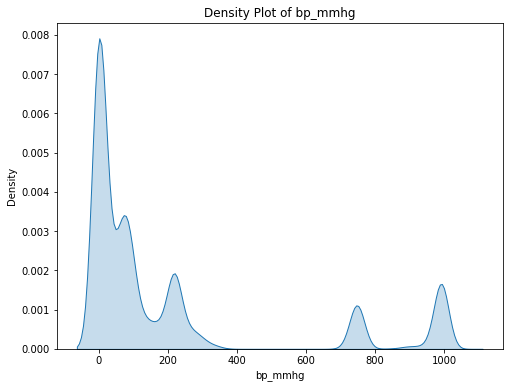

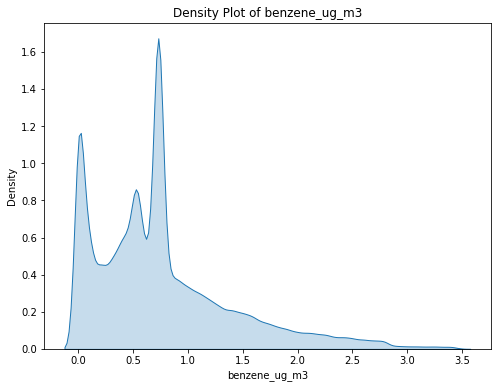

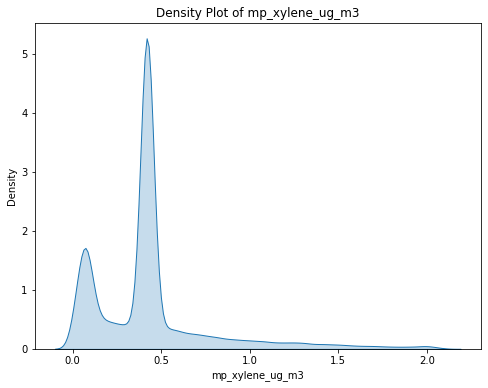

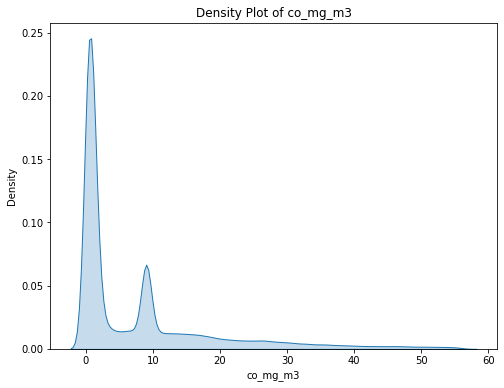

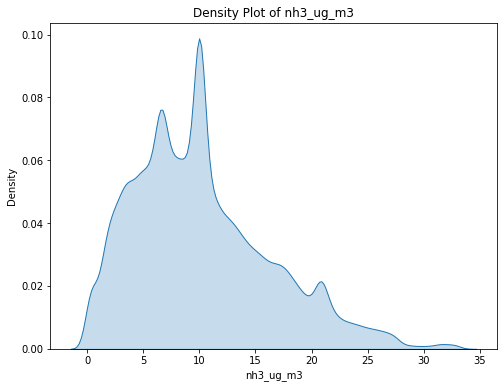

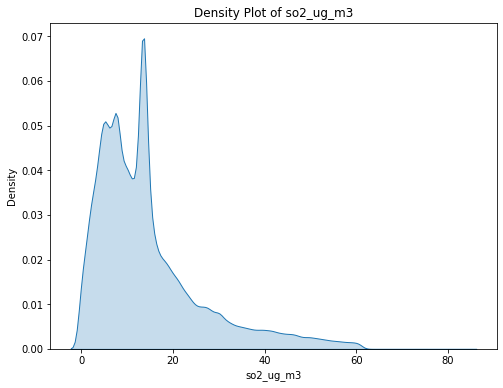

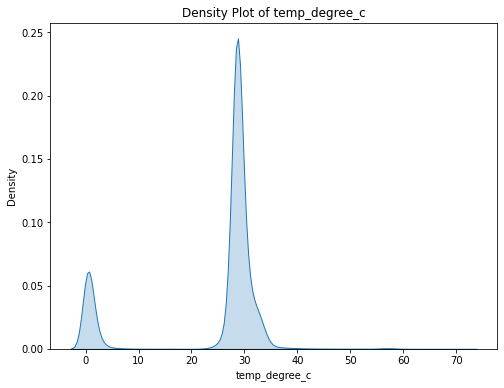

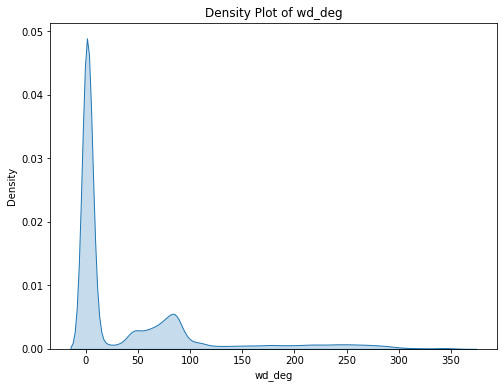

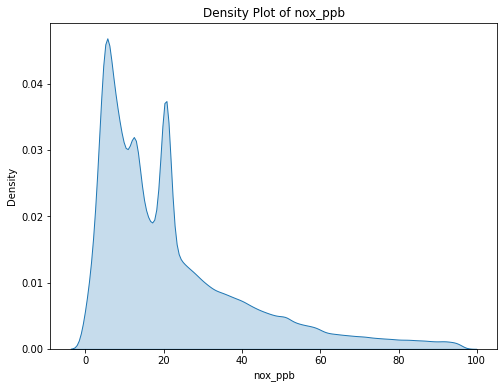

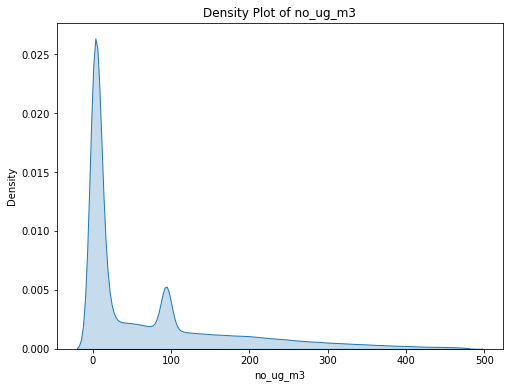

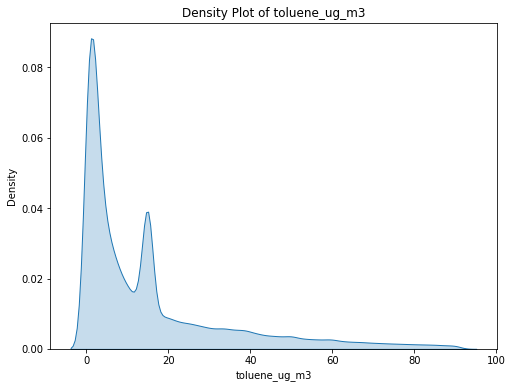

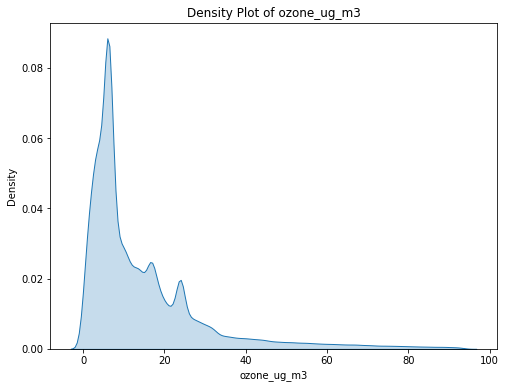

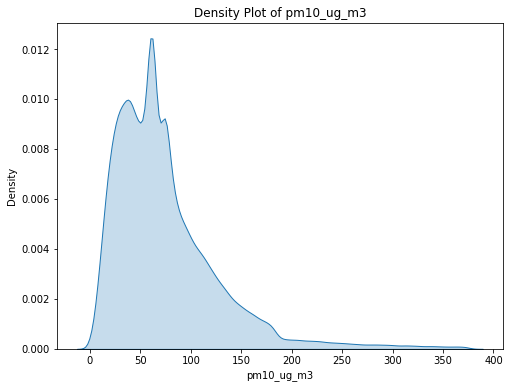

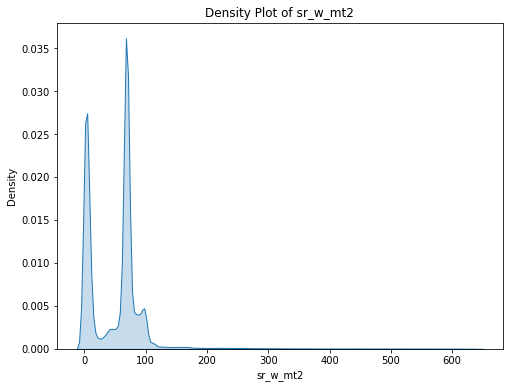

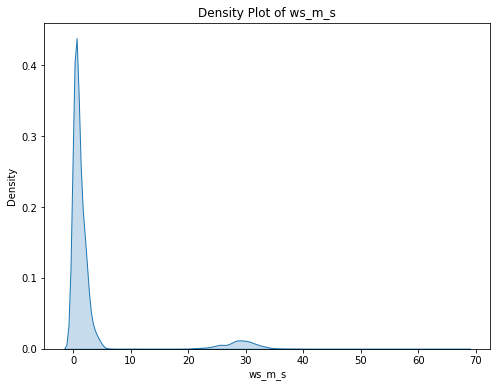

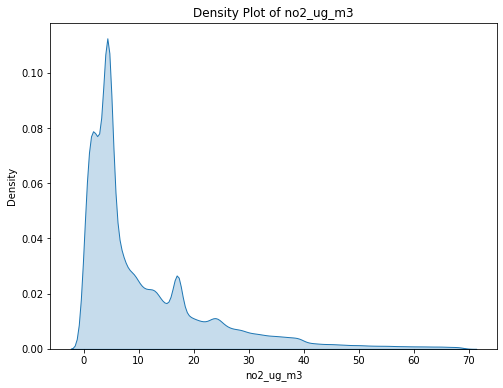

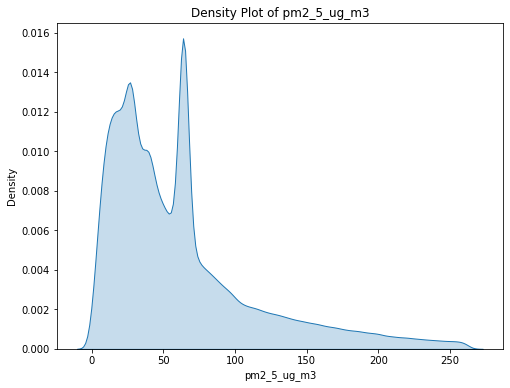

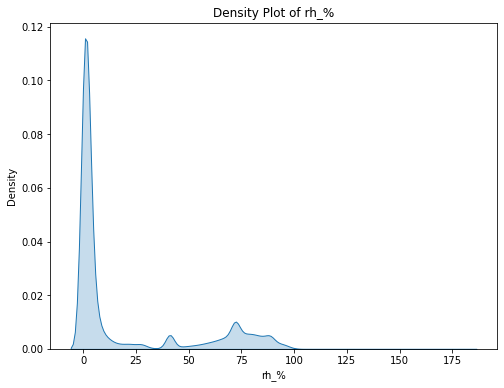

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# assume 'df' is your PySpark DataFrame

# convert the DataFrame to a Pandas DataFrame
pdf = df1_dropped.limit(800000).toPandas()

# iterate over each column and create a density plot, ignoring string columns
for col in pdf.columns:
    if pd.api.types.is_numeric_dtype(pdf[col]):
        plt.figure(figsize=(8, 6))
        sns.kdeplot(pdf[col], shade=True)
        plt.title(f"Density Plot of {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show()


In [30]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.ml.feature import Imputer

numeric_column_names = [column.name for column in df1_dropped.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]



# Initialize the Imputer
imputer = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # or "median" if you want to use the median value
)

# Fit the Imputer
model = imputer.fit(df1_dropped)

#Transform the dataset
imputed_df = model.transform(df1_dropped)

In [31]:
numeric_column_names

['bp_mmhg',
 'benzene_ug_m3',
 'mp_xylene_ug_m3',
 'o_xylene_ug_m3',
 'co_mg_m3',
 'nh3_ug_m3',
 'so2_ug_m3',
 'temp_degree_c',
 'wd_deg',
 'nox_ppb',
 'no_ug_m3',
 'toluene_ug_m3',
 'ozone_ug_m3',
 'pm10_ug_m3',
 'sr_w_mt2',
 'ws_m_s',
 'no2_ug_m3',
 'pm2_5_ug_m3',
 'rh_%']

In [32]:
# Check whether null values are still present or not
from pyspark.sql.functions import col, sum

total_count = imputed_df.count()
null_counts = imputed_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in imputed_df.columns])

null_counts_percent = null_counts.select([(col(c) / total_count) * 100 for c in null_counts.columns])

null_counts_percent_pd = null_counts_percent.toPandas().transpose()

null_counts_percent_pd.columns = ['Null Percentage']
null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].apply(lambda x: '{:.2f}%'.format(x))

null_counts_percent_pd

,Null Percentage
((bp_mmhg / 12119438) * 100),0.00%
((benzene_ug_m3 / 12119438) * 100),0.00%
((mp_xylene_ug_m3 / 12119438) * 100),0.00%
((o_xylene_ug_m3 / 12119438) * 100),0.00%
((co_mg_m3 / 12119438) * 100),0.00%
((nh3_ug_m3 / 12119438) * 100),0.00%
((so2_ug_m3 / 12119438) * 100),0.00%
((temp_degree_c / 12119438) * 100),0.00%
((from_date / 12119438) * 100),99.15%
((state / 12119438) * 100),0.00%


In [33]:
imputed_df.select("from_date").show(5)

+-------------------+
|          from_date|
+-------------------+
|2016-07-06 00:00:00|
|2016-07-16 00:00:00|
|2016-07-29 00:00:00|
|2016-08-12 00:00:00|
|2016-08-13 00:00:00|
+-------------------+
only showing top 5 rows



In [34]:
pdf = imputed_df

In [38]:
imputed_df.coalesce(1).write.parquet("file:///home/talentum/myproject/dataSource/output/final_parquet")

In [39]:
spark.stop()

# HIVE

### first read schema from file for hive

In [40]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read Parquet and Extract Schema") \
    .getOrCreate()

# Path to your Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/final_parquet/*.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(parquet_file_path)

# Extract and print the schema
schema = df.schema
print("Schema of the Parquet file:")
print(schema)

# Stop the SparkSession
spark.stop()


Schema of the Parquet file:
StructType(List(StructField(bp_mmhg,DoubleType,true),StructField(benzene_ug_m3,DoubleType,true),StructField(mp_xylene_ug_m3,DoubleType,true),StructField(o_xylene_ug_m3,DoubleType,true),StructField(co_mg_m3,DoubleType,true),StructField(nh3_ug_m3,DoubleType,true),StructField(so2_ug_m3,DoubleType,true),StructField(temp_degree_c,DoubleType,true),StructField(from_date,TimestampType,true),StructField(state,StringType,true),StructField(wd_deg,DoubleType,true),StructField(nox_ppb,DoubleType,true),StructField(no_ug_m3,DoubleType,true),StructField(toluene_ug_m3,DoubleType,true),StructField(to_date,TimestampType,true),StructField(ozone_ug_m3,DoubleType,true),StructField(pm10_ug_m3,DoubleType,true),StructField(sr_w_mt2,DoubleType,true),StructField(ws_m_s,DoubleType,true),StructField(no2_ug_m3,DoubleType,true),StructField(pm2_5_ug_m3,DoubleType,true),StructField(rh_%,DoubleType,true)))


### create table in hive

In [ ]:
# CREATE TABLE AQI (
#     bp_mmhg DOUBLE,
#     benzene_ug_m3 DOUBLE,
#     mp_xylene_ug_m3 DOUBLE,
#     o_xylene_ug_m3 DOUBLE,
#     co_mg_m3 DOUBLE,
#     nh3_ug_m3 DOUBLE,
#     so2_ug_m3 DOUBLE,
#     temp_degree_c DOUBLE,
#     from_date TIMESTAMP,
#     state STRING,
#     wd_deg DOUBLE,
#     nox_ppb DOUBLE,
#     no_ug_m3 DOUBLE,
#     toluene_ug_m3 DOUBLE,
#     to_date TIMESTAMP,
#     ozone_ug_m3 DOUBLE,
#     pm10_ug_m3 DOUBLE,
#     sr_w_mt2 DOUBLE,
#     ws_m_s DOUBLE,
#     no2_ug_m3 DOUBLE,
#     pm2_5_ug_m3 DOUBLE,
#     rh_ DOUBLE
# )
# STORED AS PARQUET;


In [41]:
from pyspark.sql import SparkSession

# Initialize Spark Session with Hive support
spark = SparkSession.builder \
    .appName("Spark Hive Integration") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

# Describe the Hive table
spark.sql("DESCRIBE project.aqi").show()

# Read a Parquet file into a DataFrame
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/final_parquet"
df = spark.read.parquet(parquet_file_path)

# Write Data to the Hive table
df.write.mode("overwrite").saveAsTable("project.aqi")

# Read the data from the Hive table
df_from_hive = spark.sql("SELECT * FROM project.aqi")

# Show the top 50 rows
df_from_hive.show(50)

# Stop the Spark session
spark.stop()


+---------------+---------+-------+
|       col_name|data_type|comment|
+---------------+---------+-------+
|        bp_mmhg|   double|   null|
|  benzene_ug_m3|   double|   null|
|mp_xylene_ug_m3|   double|   null|
| o_xylene_ug_m3|   double|   null|
|       co_mg_m3|   double|   null|
|      nh3_ug_m3|   double|   null|
|      so2_ug_m3|   double|   null|
|  temp_degree_c|   double|   null|
|      from_date|timestamp|   null|
|          state|   string|   null|
|         wd_deg|   double|   null|
|        nox_ppb|   double|   null|
|       no_ug_m3|   double|   null|
|  toluene_ug_m3|   double|   null|
|        to_date|timestamp|   null|
|    ozone_ug_m3|   double|   null|
|     pm10_ug_m3|   double|   null|
|       sr_w_mt2|   double|   null|
|         ws_m_s|   double|   null|
|      no2_ug_m3|   double|   null|
+---------------+---------+-------+
only showing top 20 rows

+-------+-------------+---------------+--------------+--------+---------+---------+-------------+-------------

In [ ]:
# spark.stop()